In [1]:
import pandas as pd
import os
import json
import numpy as np

def get_label_from_json(trial_name, question_number, label_folder_path):
    """
    Get label from corresponding JSON file if label_folder_path is provided
    """
    if not label_folder_path:  # If no path provided
        return None
        
    json_path = os.path.join(
        label_folder_path,
        f"{trial_name}.json"
    )
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
            label = data[f"Q{question_number}"]["eval_databases"]
            # Explicitly handle "N/A" to prevent pandas from converting it
            if label == "N/A":
                return "N/A"  # Forces pandas to keep it as string
            return label
    except Exception as e:
        print(f"Error reading JSON for {trial_name}: {e}")
        return None

def process_csv_and_add_labels(label_folder_1_path, label_folder_2_path, output_path):
    """
    Read files from both folders and create a CSV with labels comparison
    """
    try:
        # Get list of JSON files from folder 1
        json_files = [f for f in os.listdir(label_folder_1_path) if f.endswith('.json')]
        print(f"Found {len(json_files)} JSON files")

        # Create empty lists to store data
        data_rows = []
        
        # Process each file
        for json_file in json_files:
            trial_name = json_file.replace('.json', '')
            
            # Process each question (Q1-Q15)
            for question_num in range(1, 16):
                # Get labels from both folders
                label_1 = get_label_from_json(trial_name, question_num, label_folder_1_path)
                label_2 = get_label_from_json(trial_name, question_num, label_folder_2_path)
                
                # Add row to data
                data_rows.append({
                    'NCT_file': trial_name,
                    'Q': question_num,
                    'factual': label_1,
                    'counterfactual': label_2
                })
        
        # Create DataFrame
        df = pd.DataFrame(data_rows)
        
        # Create Final_label column based on combinations
        print("Creating Final_label column...")
        conditions = [
            (df['factual'] == 'fact') & (df['counterfactual'] == 'fact'),
            (df['factual'] == 'hallucination') & (df['counterfactual'] == 'hallucination'),
            (df['factual'] == 'fact') & (df['counterfactual'] == 'hallucination'),
            (df['factual'] == 'hallucination') & (df['counterfactual'] == 'fact')
        ]
        
        choices = ['fact', 'hallucination', 'error', 'coverage']
        
        df['Final_label'] = np.select(conditions, choices, default='N/A')
        
        # Save the DataFrame
        print(f"Saving CSV to: {output_path}")
        df.to_csv(output_path, index=False)
        
        # Print summary
        print("\nProcessing complete!")
        print(f"Total rows processed: {len(df)}")
        print("\nFactual distribution:")
        print(df['factual'].value_counts(dropna=False))
        print("\nCounterfactual distribution:")
        print(df['counterfactual'].value_counts(dropna=False))
        print("\nFinal_label distribution:")
        print(df['Final_label'].value_counts(dropna=False))
        print("\nDetailed combination counts:")
        print(pd.crosstab(df['factual'], df['counterfactual'], margins=True))
        
    except Exception as e:
        print(f"Error processing files: {e}")
        return None

# Example usage
if __name__ == "__main__":
    # Define paths
    label_folder_1_path = "Database_dependent_evaluation/Clinical_trials/5-Labels/Inference_files_with_labels/DeepSeek/Paragraph_level/Inference_title_Paragraph"
    label_folder_2_path = "Database_dependent_evaluation/Clinical_trials/5-Labels/Inference_files_with_labels_counterfactual/DeepSeek/Paragraph_level/Inference_title_Paragraph"
    output_path = "Paragraph_DeepSeek_json.csv"
    
    # Process the files and add labels
    process_csv_and_add_labels(label_folder_1_path, label_folder_2_path, output_path)

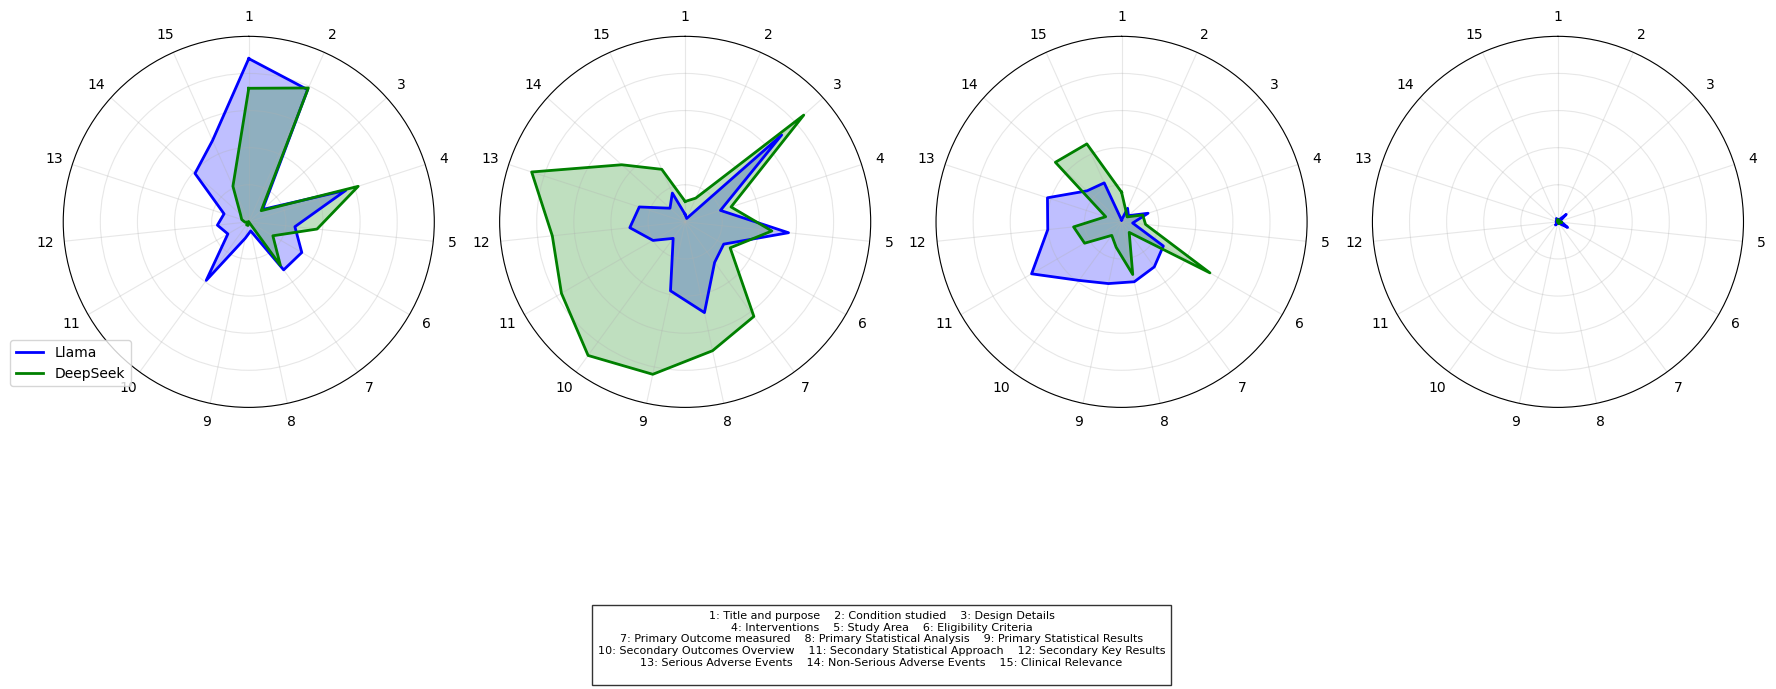

In [9]:
def plot_normalized_label_comparison_radar(csv_paths):
    """
    Create four radar plots with categories legend in 5 columns at the bottom
    """
    dfs = {
        'Llama': pd.read_csv(csv_paths['summary']),
        'DeepSeek': pd.read_csv(csv_paths['title']),
    }
    
    # Define categories
    categories = {
        1: 'Title and purpose',
        2: 'Condition studied',
        3: 'Design Details',
        4: 'Interventions',
        5: 'Study Area',
        6: 'Eligibility Criteria',
        7: 'Primary Outcome measured',
        8: 'Primary Statistical Analysis',
        9: 'Primary Statistical Results',
        10: 'Secondary Outcomes Overview',
        11: 'Secondary Statistical Approach',
        12: 'Secondary Key Results',
        13: 'Serious Adverse Events',
        14: 'Non-Serious Adverse Events',
        15: 'Clinical Relevance'
    }
    
    # Create figure with space at bottom for categories
    fig = plt.figure(figsize=(18, 8))
    
    # Create gridspec with space for radar plots and category legend
    gs = fig.add_gridspec(2, 4, height_ratios=[4, 1])
    
    # Create axes for radar plots in top row
    axes = [fig.add_subplot(gs[0, i], projection='polar') for i in range(4)]
    
    labels = ['fact', 'hallucination', 'coverage', 'error']
    colors = {'Llama': 'blue', 'DeepSeek': 'green'}
    q_order = [i for i in range(1, 16)]
    angles = np.linspace(0, 2*np.pi, len(q_order), endpoint=False)
    
    # Store lines for input type legend
    legend_lines = []
    legend_labels = []
    
    for idx, label in enumerate(labels):
        ax = axes[idx]
        
        for input_type, df in dfs.items():
            rates = []
            for q in q_order:
                q_total = len(df[df['Q'] == q])
                if q_total > 0:
                    q_label_count = len(df[(df['Q'] == q) & (df['Final_label'] == label)])
                    rates.append(q_label_count / q_total)
                else:
                    rates.append(0)
            
            rates.append(rates[0])
            angles_plot = np.concatenate((angles, [angles[0]]))
            
            line = ax.plot(angles_plot, rates, color=colors[input_type], linewidth=2)[0]
            ax.fill(angles_plot, rates, color=colors[input_type], alpha=0.25)
            
            if idx == 0:
                legend_lines.append(line)
                legend_labels.append(input_type)
        
        # ax.set_title(f'{label.capitalize()}')
        ax.set_xticks(angles)
        ax.set_xticklabels(q_order)
        ax.set_ylim(0, 1)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_yticklabels([])
        ax.grid(True, alpha=0.3)
    
    # Add input type legend to the first radar plot
    axes[0].legend(legend_lines, legend_labels, 
                  loc='upper right',
                  bbox_to_anchor=(0.2, 0.2))
    
    # Create text for categories in 5 columns
    items_per_column = 3
    num_columns = 5
    category_text = ''
    
    for col in range(num_columns):
        column_items = []
        for i in range(items_per_column):
            idx = col * items_per_column + i
            if idx < len(categories):
                column_items.append(f'{idx+1}: {categories[idx+1]}')
        category_text += '    '.join(column_items) + '\n'
    
    # Add categories legend at bottom
    fig.text(0.5, 0.05, category_text,
             fontsize=8,
             horizontalalignment='center',
             verticalalignment='center',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('input_type_comparison_radar.png', dpi=600, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    csv_paths = {
        'summary': "Paragraph_Llama_title.csv",      # Replace with your Llama CSV file
        'title': "Paragraph_DeepSeek_title.csv"  # Replace with your DeepSeek CSV file
    }
    
    plot_normalized_label_comparison_radar(csv_paths)